<a href="https://colab.research.google.com/github/Aleomar15/CNNFaces/blob/main/CNNFaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import os

In [ ]:
# Evitando erros de OOM configurando o crescimento do consumo de memória da GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Removendo imagens incoerentes

In [ ]:
import cv2
import imghdr

In [ ]:
data_dir = "/content/drive/MyDrive/Batch_Ready 7"

In [ ]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [ ]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Está imagem não esta na lista{}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Problema com imagem {}'.format(image_path))
            # os.remove(image_path)

# Carregando as imagens

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/Batch_Ready 7')

Found 2100 files belonging to 7 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
batch = data_iterator.next()

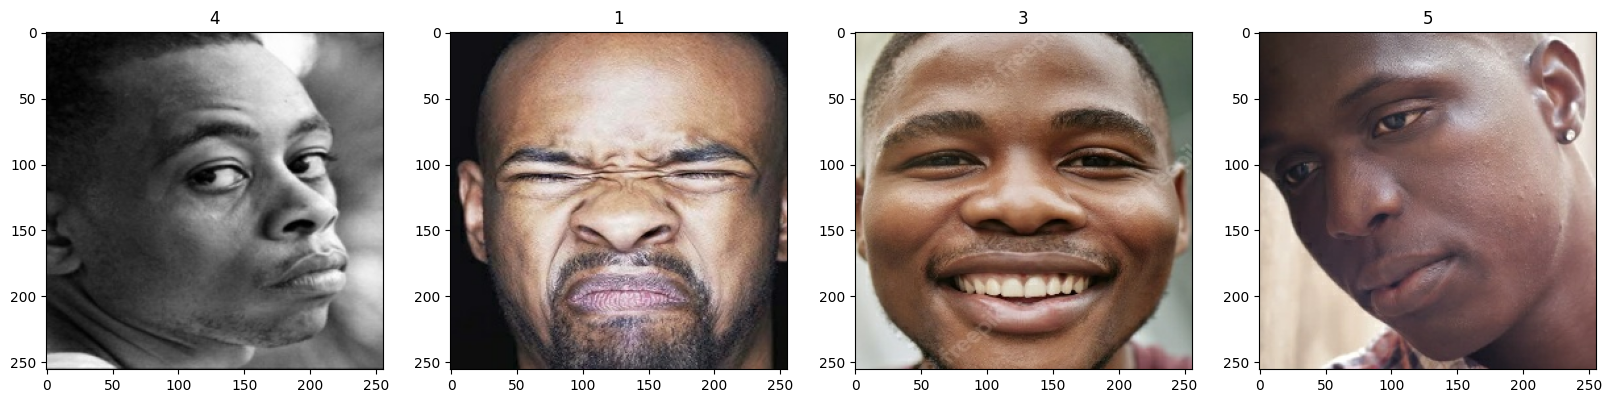

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Dimensionando dados

In [ ]:
data = data.map(lambda x,y: (x/255, y))

In [ ]:
data.as_numpy_iterator().next()

(array([[[[0.99607843, 0.99607843, 0.99607843],
          [0.99215686, 0.99215686, 0.99215686],
          [0.99215686, 0.99215686, 0.99215686],
          ...,
          [0.07843138, 0.07058824, 0.09019608],
          [0.09803922, 0.09019608, 0.10980392],
          [0.10196079, 0.09411765, 0.11372549]],
 
         [[0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          ...,
          [0.07843138, 0.07058824, 0.09019608],
          [0.09411765, 0.08627451, 0.10588235],
          [0.10196079, 0.09411765, 0.11372549]],
 
         [[0.99607843, 0.99607843, 0.9882353 ],
          [0.99607843, 0.99607843, 0.9882353 ],
          [0.99607843, 0.99607843, 0.9882353 ],
          ...,
          [0.08235294, 0.07450981, 0.09411765],
          [0.09019608, 0.08235294, 0.10196079],
          [0.10196079, 0.09411765, 0.11372549]],
 
         ...,
 
         [[0.87058824, 0.827451  , 0.89411765],
          [0.65490

# Dividindo Dados

In [ ]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [ ]:
train_size

46

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [ ]:
train = train.map(lambda x, y: (x, tf.one_hot(y, depth=7)))
val = val.map(lambda x, y: (x, tf.one_hot(y, depth=7)))
test = test.map(lambda x, y: (x, tf.one_hot(y, depth=7)))

# Contruindo o modelo de CNN(ou Deep Learning)

In [ ]:
train

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>

In [ ]:
from tensorflow.keras.models import Sequential #Sequential = ResNet-50
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam


In [ ]:
model = Sequential()

In [ ]:
model = Sequential()
model.add(Conv2D(16, (5, 5),1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(32, (5, 5),1, activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(16, (5, 5),1, activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [ ]:
optimizer = Adam(learning_rate=0.001)  # Ajuste a taxa de aprendizado
model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 126, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 32)      12832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 61, 61, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 57, 57, 16)        12816     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 16)       

# Treino

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
46/46 [==============================] - 19s 157ms/step - loss: 1.9925 - accuracy: 0.1644 - val_loss: 1.9070 - val_accuracy: 0.1899
Epoch 2/20
46/46 [==============================] - 7s 149ms/step - loss: 1.8349 - accuracy: 0.3064 - val_loss: 1.7154 - val_accuracy: 0.3293
Epoch 3/20
46/46 [==============================] - 8s 168ms/step - loss: 1.5962 - accuracy: 0.4198 - val_loss: 1.5463 - val_accuracy: 0.4255
Epoch 4/20
46/46 [==============================] - 6s 131ms/step - loss: 1.3546 - accuracy: 0.5217 - val_loss: 1.4268 - val_accuracy: 0.4784
Epoch 5/20
46/46 [==============================] - 7s 142ms/step - loss: 1.0307 - accuracy: 0.6352 - val_loss: 1.4289 - val_accuracy: 0.5625
Epoch 6/20
46/46 [==============================] - 7s 145ms/step - loss: 0.7072 - accuracy: 0.7656 - val_loss: 1.3870 - val_accuracy: 0.6202
Epoch 7/20
46/46 [==============================] - 7s 141ms/step - loss: 0.3488 - accuracy: 0.8927 - val_loss: 1.7363 - val_accuracy: 0.6298
Epoch

# Medindo e mostrando performace

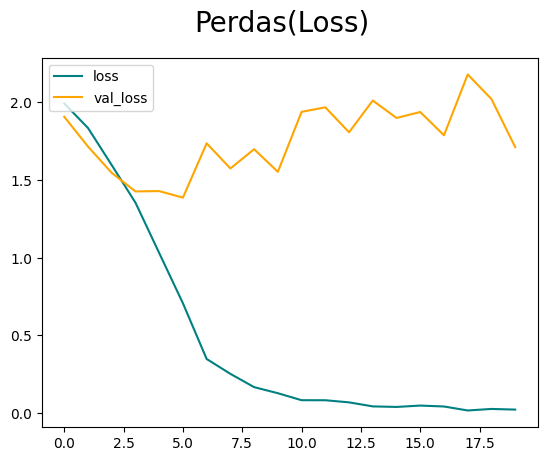

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Perdas(Loss)', fontsize=20)
plt.legend(loc="upper left")
plt.show()

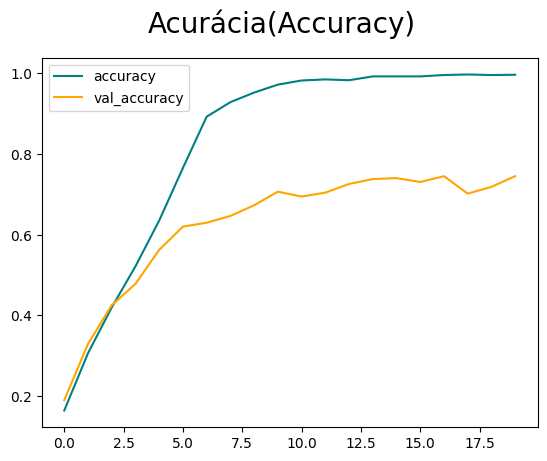

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Acurácia(Accuracy)', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Avaliando a CNN

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, F1Score, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
f1 = F1Score(average='macro')
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    y = y.reshape(-1, 1)  # Remodela os rótulos para (batch_size, 1)
    yhat = yhat.reshape(-1, 1)  # Remodela as previsões para (batch_size, 1)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    f1.update_state(y, yhat)



1/1 [==============================] - 0s 36ms/step


In [ ]:
print(pre.result(), re.result(), acc.result(), f1.result())

tf.Tensor(0.6505376, shape=(), dtype=float32) tf.Tensor(0.6302083, shape=(), dtype=float32) tf.Tensor(0.89880955, shape=(), dtype=float32) tf.Tensor(0.2622951, shape=(), dtype=float32)
